# survey data experiments: combined RPLM 

Random parameter logit model

Test a model that uses results from v0,v1,v2,v3

Note v1 has different attribute levels. 
How to handle all vendors at once?

Idea 1:

- Only include choices where time = 30mins (1/16 data points)
- 30mins is a shared attribute level across all vendor types
- No time parameter; just cost and privacy

Use a random coefficient model for cost.

Reminder about parameter coding: 
- drone choice=1
- ground choice=0

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [2]:
choices_df = pd.read_csv(transformed_data_filepath)
choices_df.head()

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,freq_takeout_food,v_type,g_cost,d_cost,g_time,d_time,d_privacy,d_time - g_time,d_cost - g_cost,ID
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,1,liquor store,0,0,20,15,0,-5,0,0
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,1,liquor store,3,0,20,20,0,0,-3,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,1,take-out food,0,3,45,20,0,-25,3,0
3,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc3_gt0_dc0_dt2_dp0_1.1,1,1,3,0,0,2,0,1,...,1,prescription medications,10,0,30,360,0,330,-10,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,1,liquor store,5,0,45,45,0,0,-5,0


In [3]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

color_ground = 'blue'
color_drone = 'red'

def plot_points_tradeoff_by_size(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

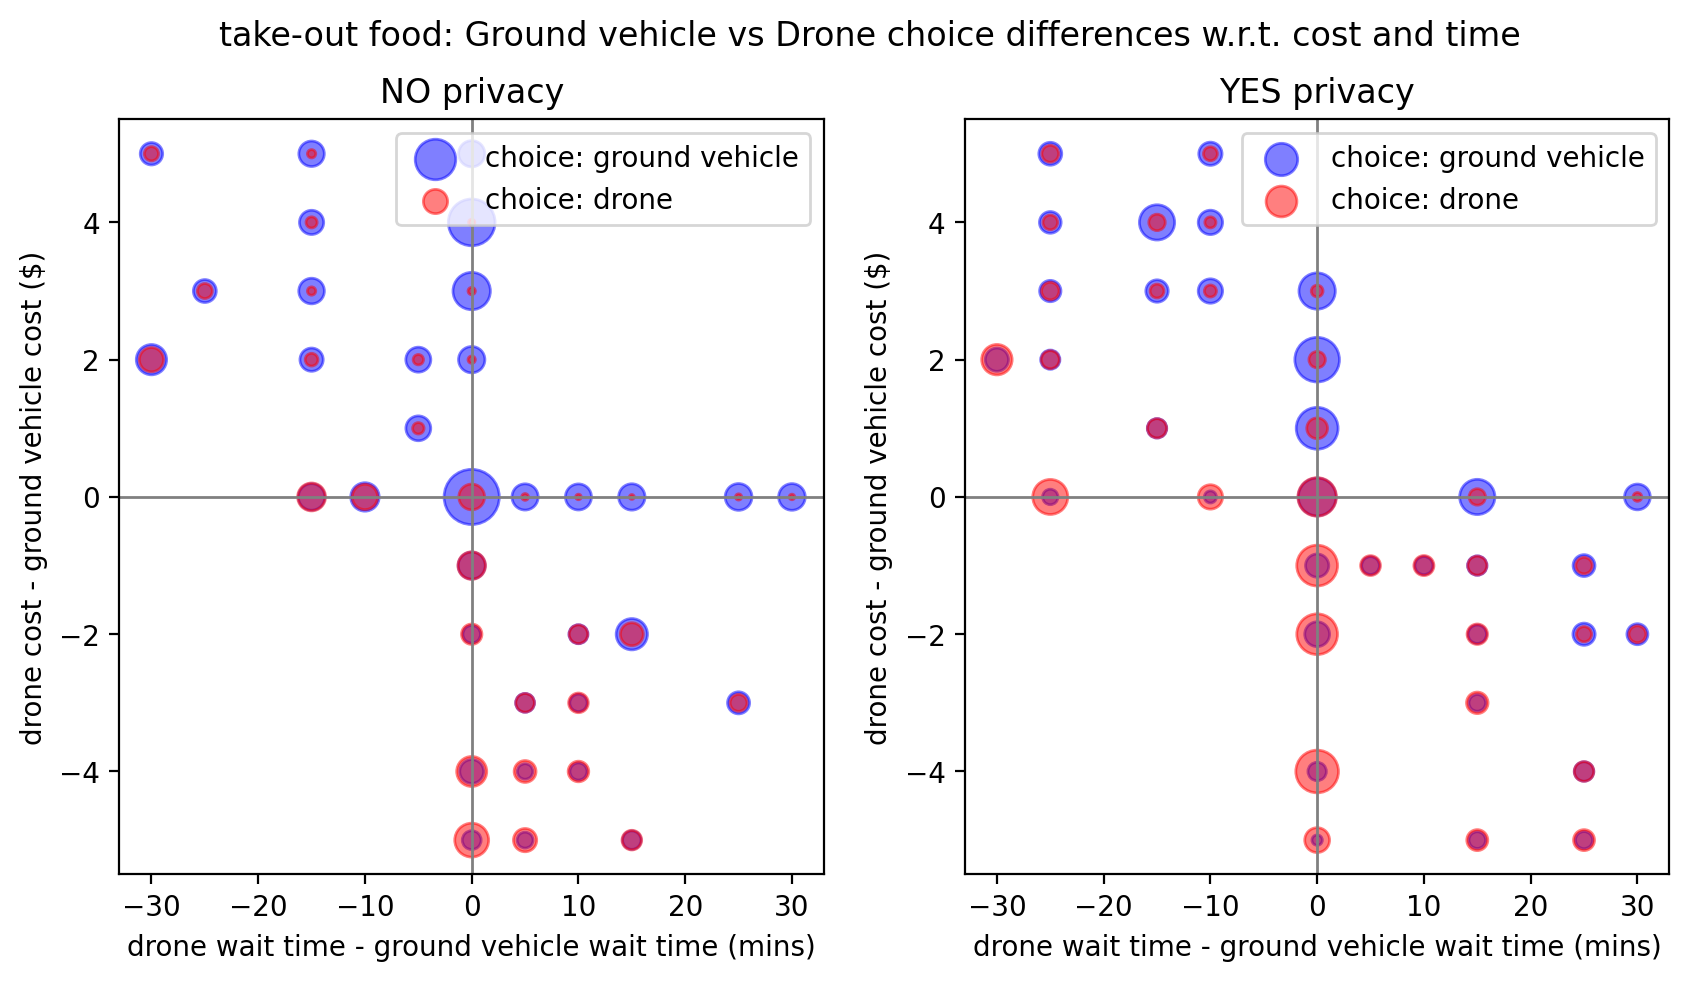

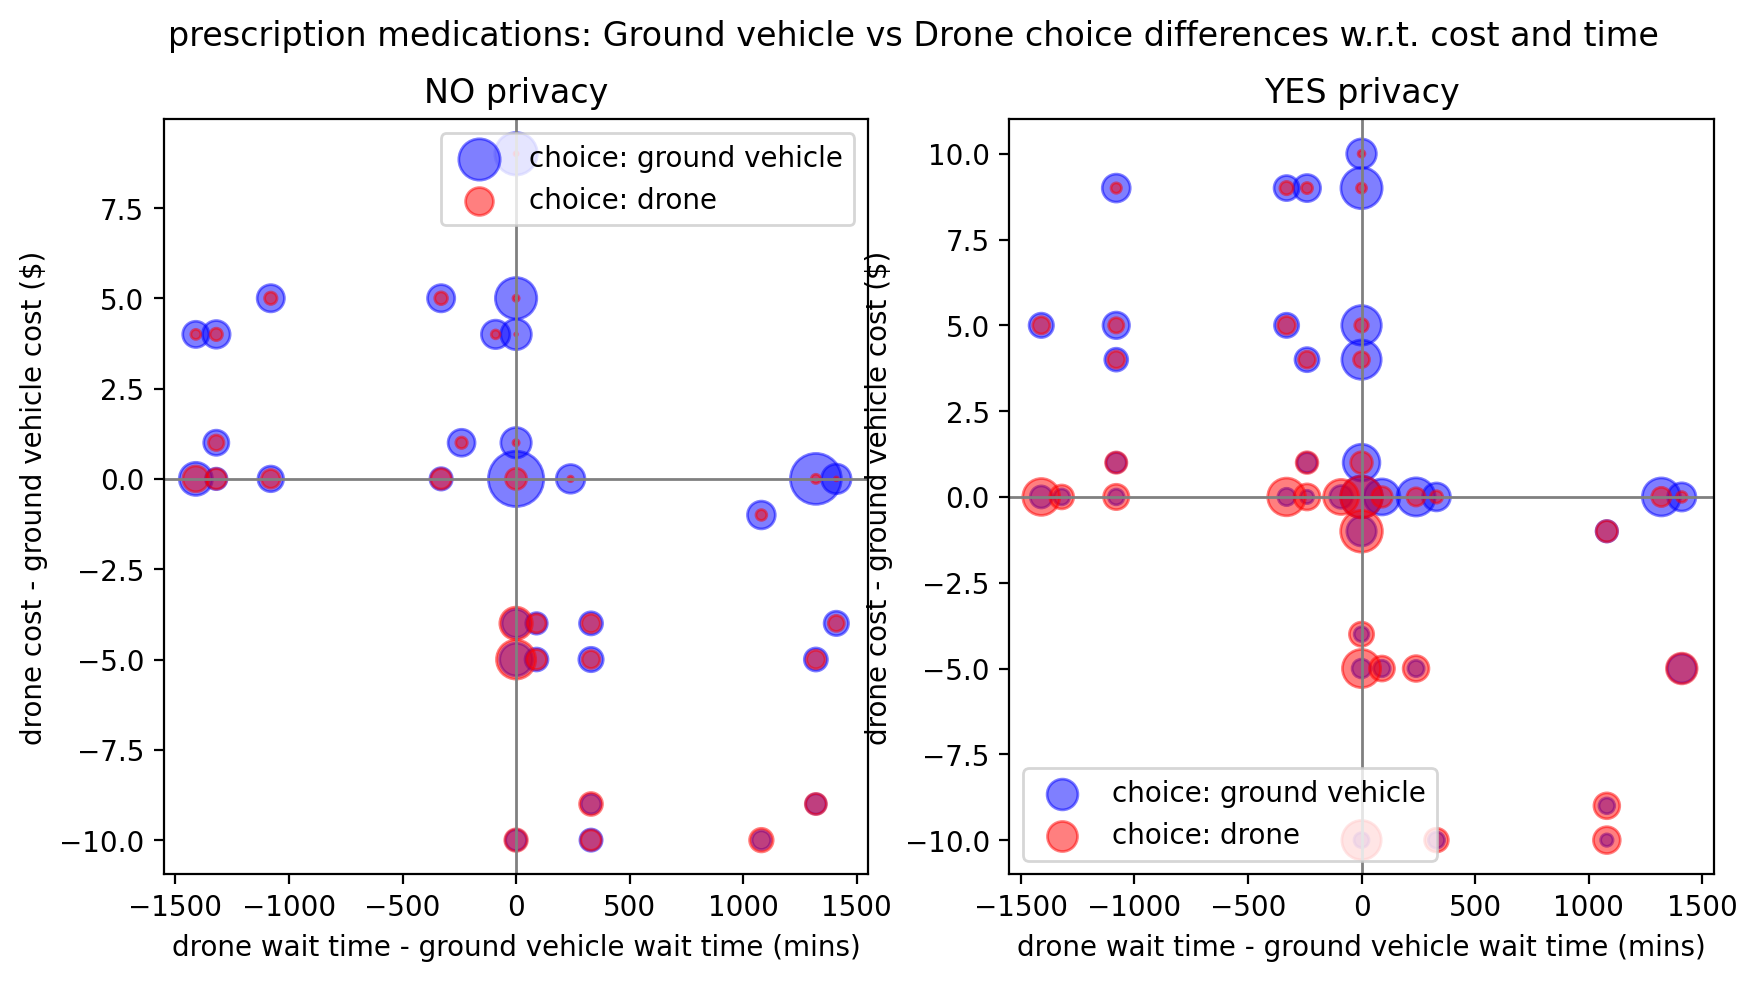

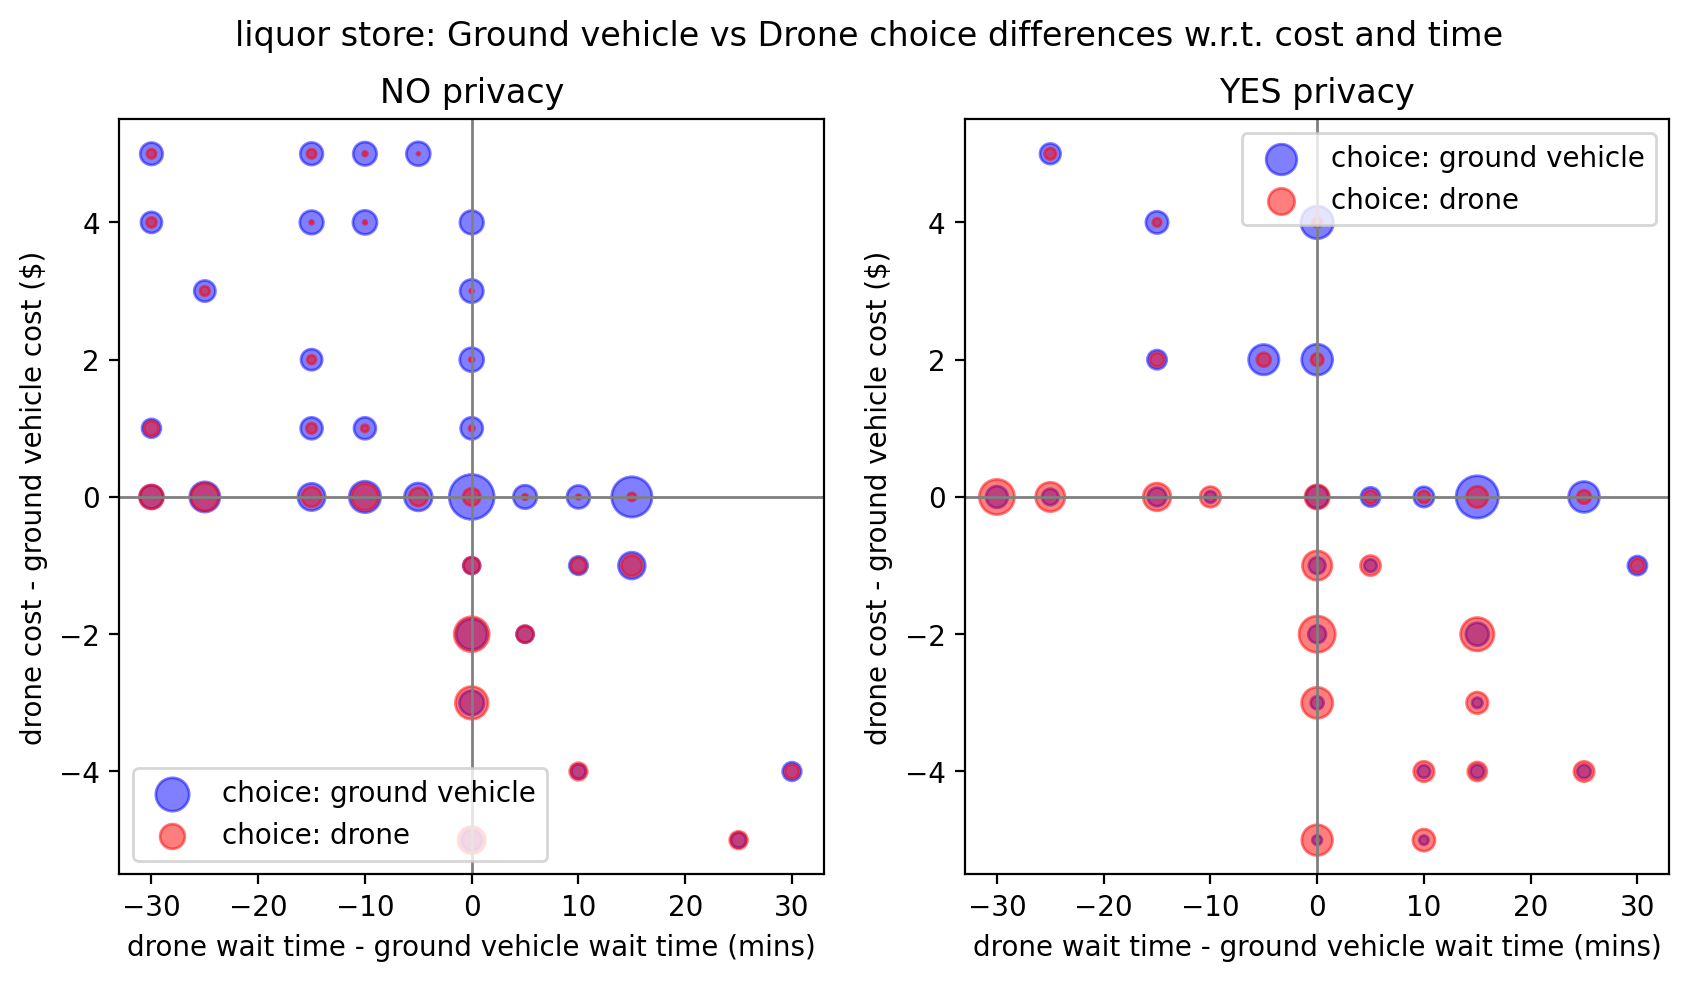

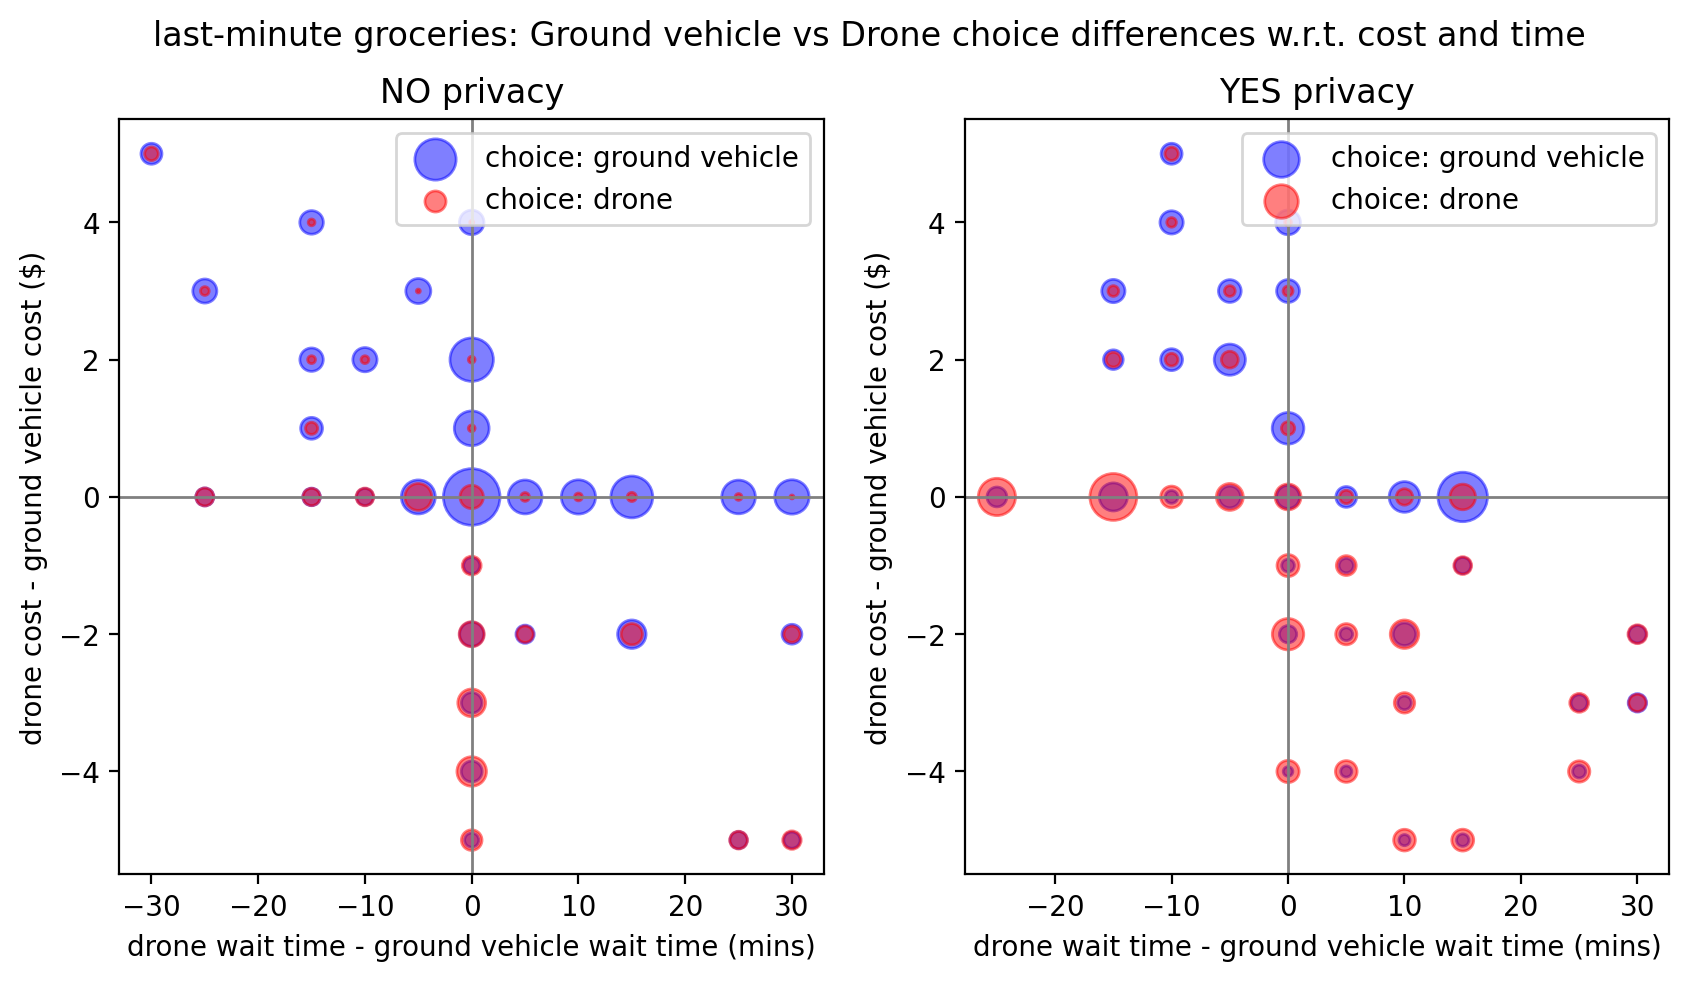

In [4]:
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_df[choices_df['v']==v]
    plot_points_tradeoff_by_size(vdf, vendor_type[0])

#### Add a dummy variable for each vendor type

In [23]:
choices_df['takeout_food'] = choices_df['v'].apply(lambda v: 1 if v==0 else 0)
choices_df['medications'] = choices_df['v'].apply(lambda v: 1 if v==1 else 0)
choices_df['liquor_store'] = choices_df['v'].apply(lambda v: 1 if v==2 else 0)
choices_df['groceries'] = choices_df['v'].apply(lambda v: 1 if v==3 else 0)

Try limiting to just time = 30mins

In [24]:
choices_t30_df = choices_df[(choices_df['g_time']==30) & (choices_df['d_time']==30)]
print('%s/%s choices with time = 30 mins across all vendors and mode types' % (
    len(choices_t30_df), len(choices_df)))
choices_t30_df.head()

3266/36297 choices with time = 30 mins across all vendors and mode types


,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,g_time,d_time,d_privacy,d_time - g_time,d_cost - g_cost,ID,takeout_food,medications,liquor_store,groceries
5,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc0_gt0_dc1_dt0_dp1_1.1,0,1,0,0,1,0,1,1,...,30,30,1,0,1,0,0,1,0,0
33,R_1MR2SvVMCux6Cwe,CHOICE_v2_gc3_gt2_dc2_dt2_dp1_1.1,0,2,3,2,2,2,1,1,...,30,30,1,0,-2,3,0,0,1,0
37,R_1MR2SvVMCux6Cwe,CHOICE_v3_gc2_gt2_dc0_dt2_dp0_1.1,0,3,2,2,0,2,0,1,...,30,30,0,0,-3,3,0,0,0,1
43,R_1MR2SvVMCux6Cwe,CHOICE_v0_gc0_gt2_dc1_dt2_dp1_1.1,0,0,0,2,1,2,1,1,...,30,30,1,0,1,3,1,0,0,0
53,R_2sSZQeFyNBEsUjH,CHOICE_v0_gc1_gt2_dc3_dt2_dp0_1.1,0,0,1,2,3,2,0,0,...,30,30,0,0,4,4,1,0,0,0


In [25]:
len(choices_t30_df[choices_t30_df['v']==1])

922

In [26]:
def plot_points_cost(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_cost','g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_cost','g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_cost'],
            df_p_agg['g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_cost'],
            df_p_agg['g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('(\$) drone cost')
        ax.set_ylabel('(\$) ground vehicle cost')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost' % vendor)
    _ = fig.suptitle(title)

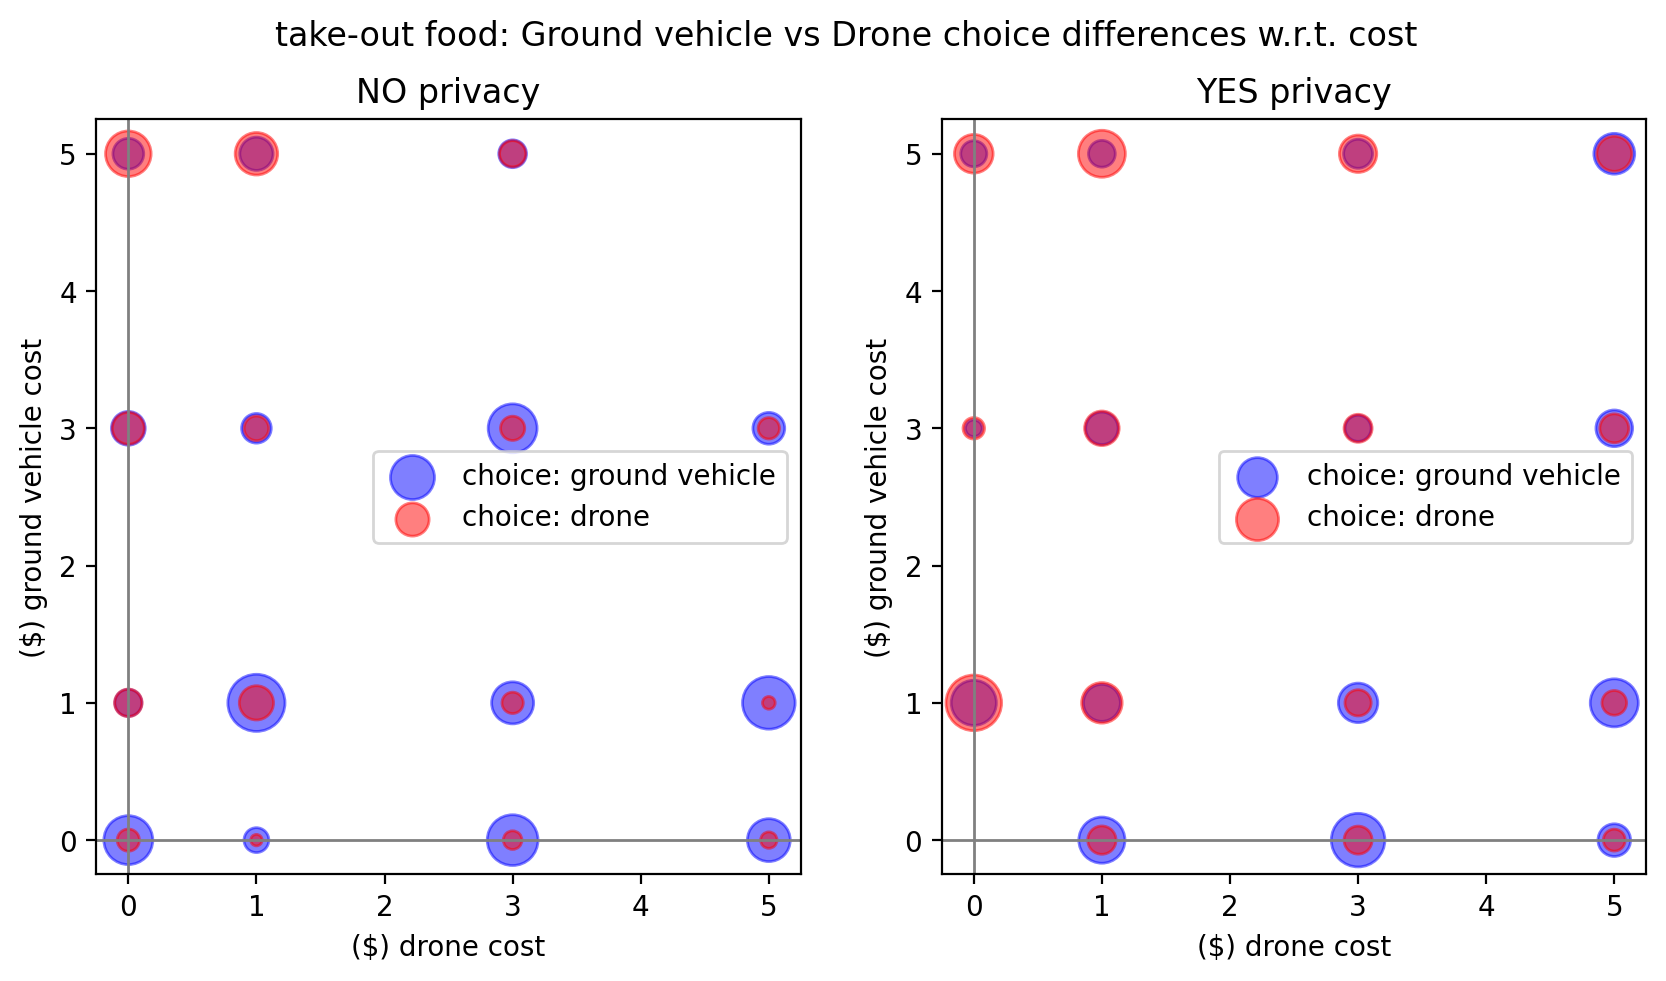

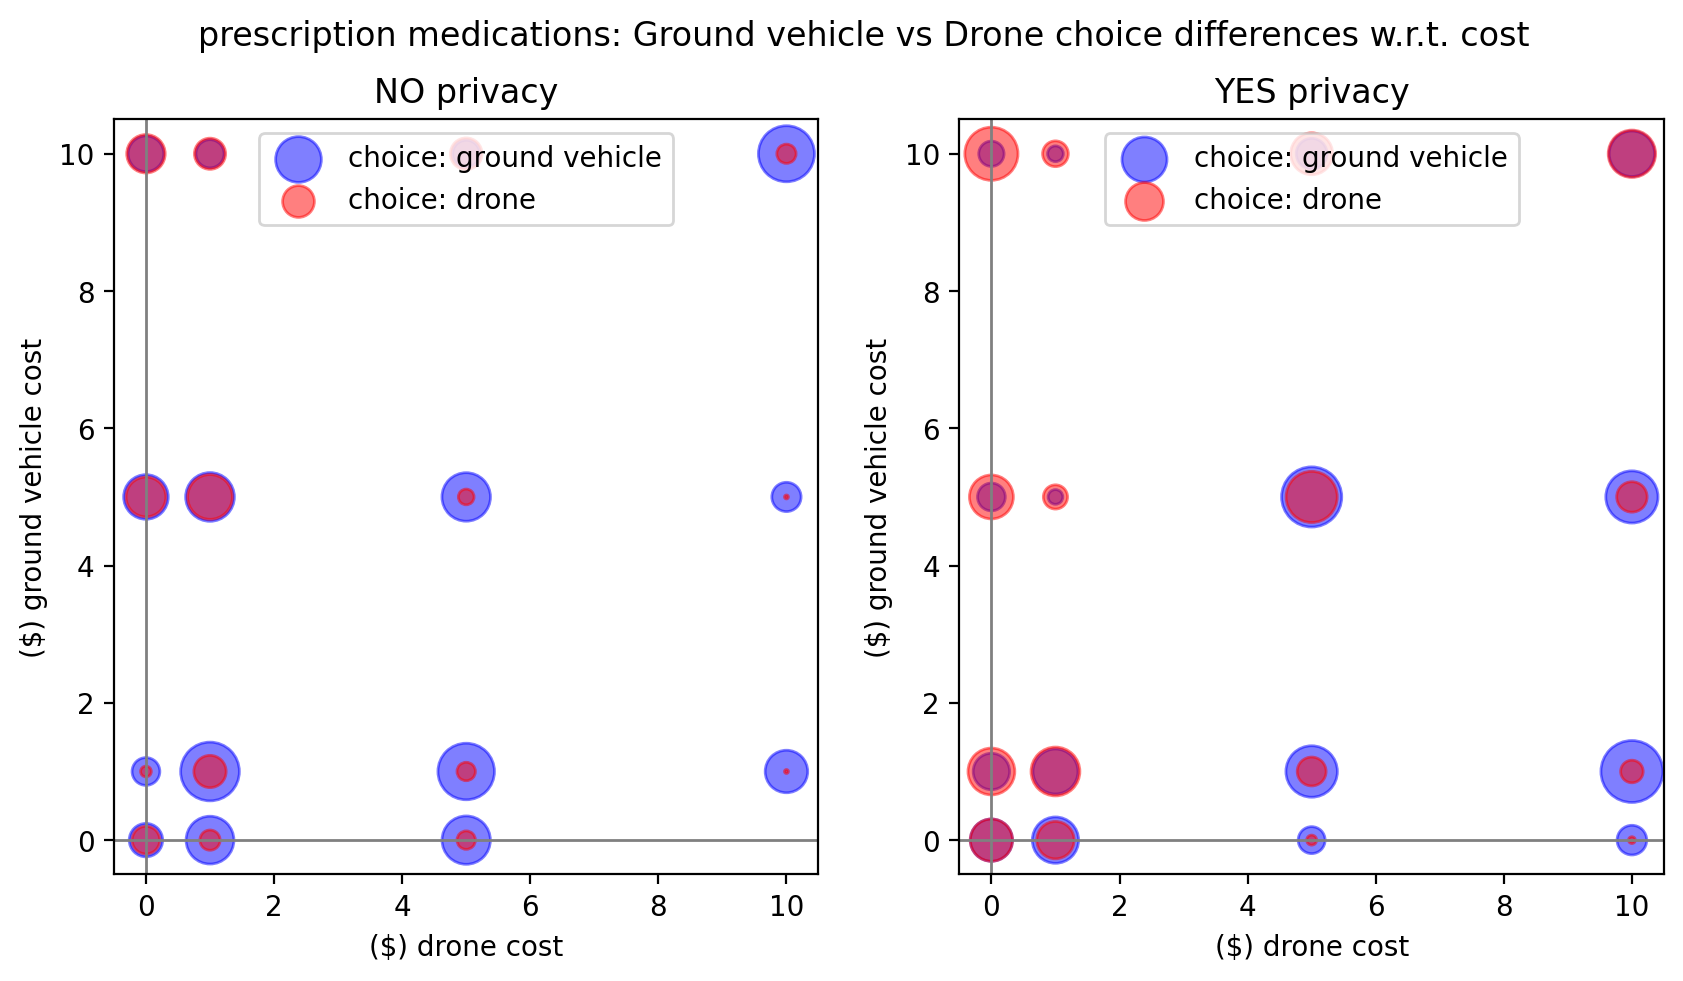

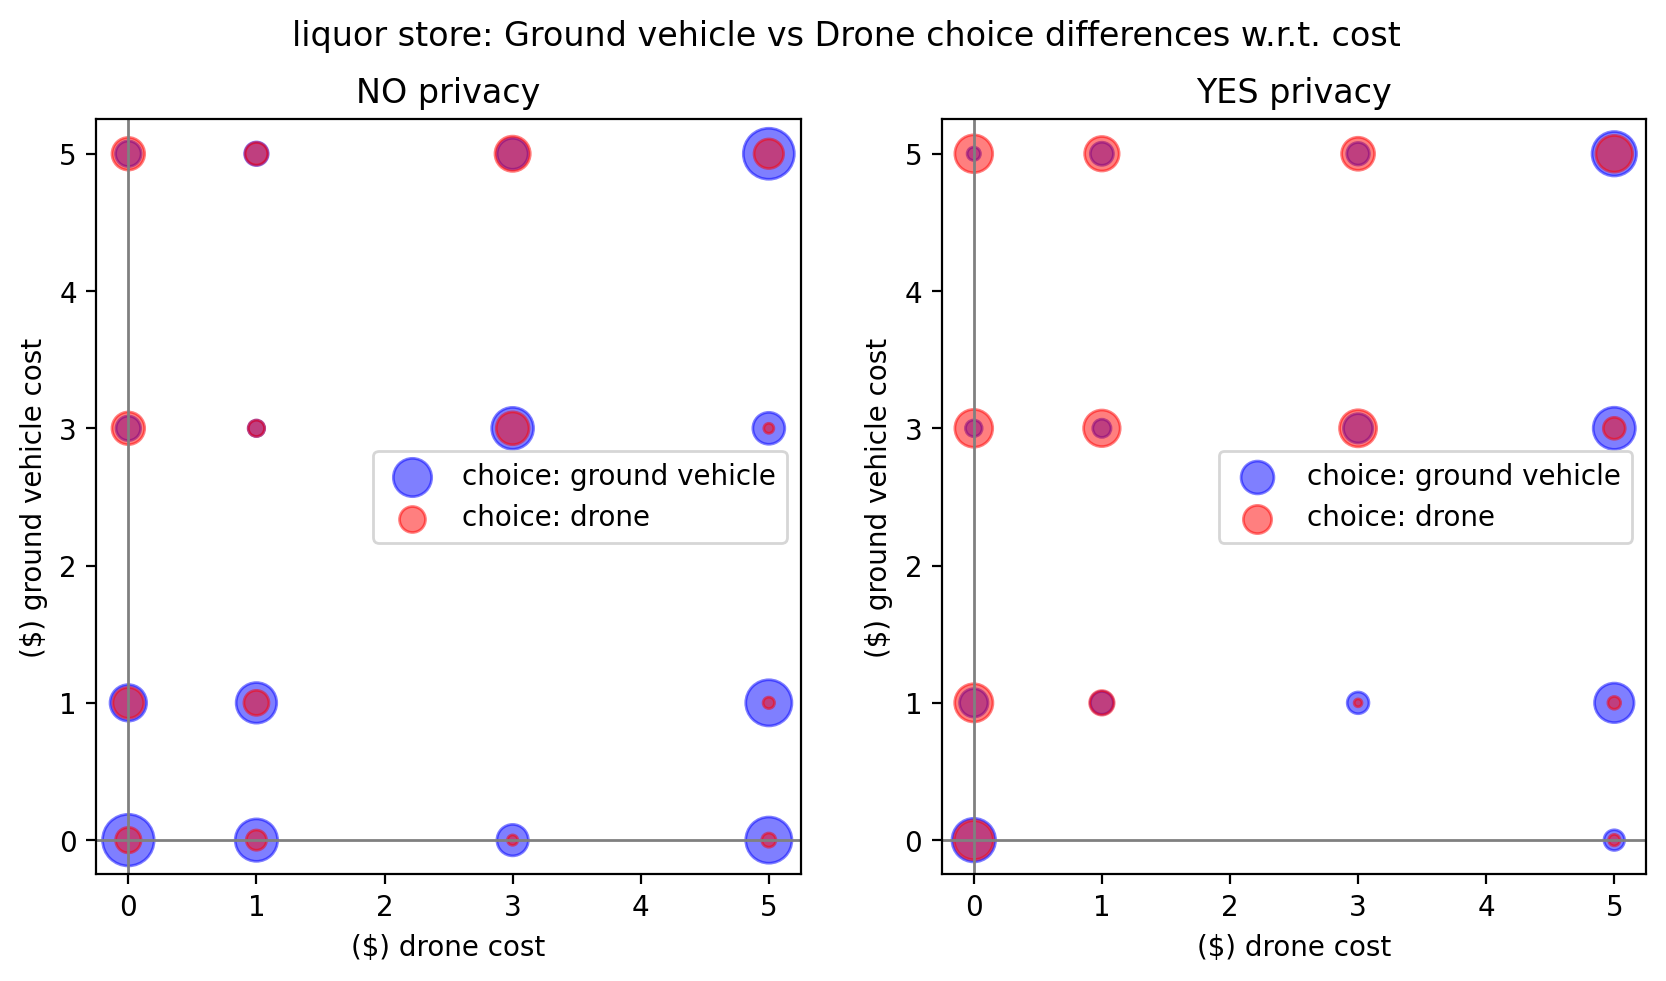

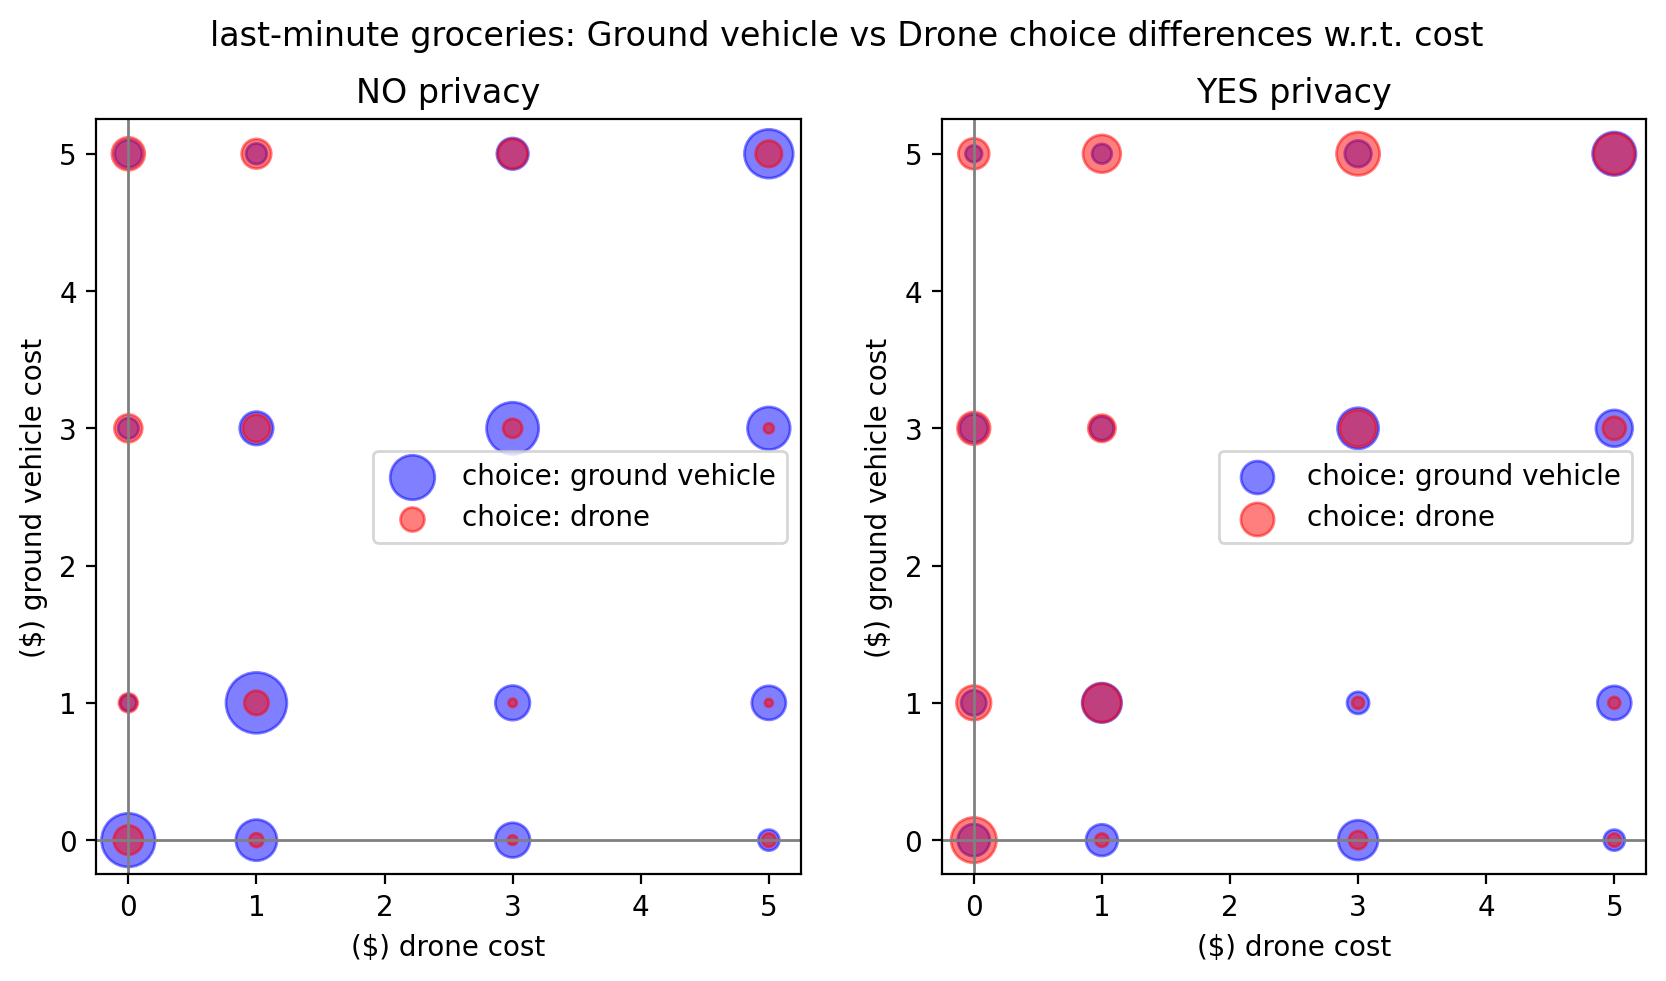

In [27]:
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_df[choices_df['v']==v]
    plot_points_cost(vdf, vendor_type[0])

## Biogeme

Documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf


In [28]:
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

In [29]:
model_choice_cols = [
    'ID',         # respondent ID - to model agent level effect
    
    'choice',     # 0=ground vehicle; 1=drone
    'g_cost',     # ground vehicle delivery cost
    'd_cost',     # drone delivery cost
    #'g_time',     # ground vehicle delivery wait time
    #'d_time',     # drone delivery wait time
    'd_privacy',  # 0=NO PRIVACY; 1=YES PRIVACY (for drone delivery)
     
    # dummy code vendor type
    'takeout_food', 'medications', 'liquor_store', 'groceries',
    
    # dummy coded (0/1)
    'male',       # 1=male; 0=otherwise
    'age_young',
    'age_old',
    'residence_house',
    'residence_apartment',
    'urban',
    'suburban',
    'rural',
    
    'freq_ecommerce',
    'freq_takeout_food',
    
]

In [40]:
def get_vendor_panel_database(name='v-all', free_col=True):
    """Returns new fresh database each time."""
    db_name = name
    df = choices_t30_df[model_choice_cols].copy()
    if free_col:
        df['g_free'] = df['g_cost'].apply(lambda c: 1 if c==0 else 0)
        df['d_free'] = df['d_cost'].apply(lambda c: 1 if c==0 else 0)
    database = db.Database(db_name, df)
    database.panel('ID')
    return database

In [41]:
database = get_vendor_panel_database()
database.data.head()

,ID,choice,g_cost,d_cost,d_privacy,takeout_food,medications,liquor_store,groceries,male,...,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,g_free,d_free,_biogroups
0,0,0,0,1,1,0,1,0,0,1,...,0,1,1,0,0,0,1,1,0,1
1,3,0,5,3,1,0,0,1,0,1,...,1,0,0,0,1,0,0,0,0,2
2,3,0,3,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,1,2
3,3,0,0,1,1,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,2
4,4,0,1,5,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,3


In [42]:
database = get_vendor_panel_database()
# To use the names of variables as Python variables.
globals().update(database.variables)
# print(database.variables)
# The Pandas data structure is available as database.data. Use all the
# Pandas functions to invesigate the database
database.data.describe()

,ID,choice,g_cost,d_cost,d_privacy,takeout_food,medications,liquor_store,groceries,male,...,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,g_free,d_free,_biogroups
count,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,...,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000
mean,1865.152480,0.461421,3.303123,1.802511,0.480710,0.316901,0.282303,0.176363,0.224434,0.486222,...,0.699939,0.277097,0.276179,0.560012,0.157685,0.208206,0.067667,0.203001,0.326087,1098.237293
std,1068.309236,0.498586,2.806900,1.925219,0.499704,0.465340,0.450189,0.381187,0.417273,0.499887,...,0.458354,0.447634,0.447175,0.496461,0.364501,0.406087,0.251212,0.402295,0.468851,640.257929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,959.250000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,539.250000
50%,1855.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1100.000000
75%,2793.750000,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1657.750000
max,3714.000000,1.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2200.000000


In [43]:
# https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# results.data.sampleSize: the sample size N.
# results.data.numberOfObservations: the number of rows in the data file. If the data is not panel, it is the same as the sample size.
# results.data.nparam: the number K of estimated parameters.
# results.data.logLike: the value L∗ of the log likelihood at the final value of the parameters.

def print_biogeme_results(results):
    print('Model: %s' % results.data.modelName)
    print('\n---- Coefficients ----')
    print(results.getEstimatedParameters())
    print('\n---- Model statistics ----\n')
    print('sample size: N=%s' % results.data.sampleSize)
    print('observations: n=%s' % results.data.numberOfObservations)
    print('no. of parameters: K=%s' % results.data.nparam)
    print('log likelihood: LL=%s' % results.data.logLike)
    print('adjusted likelihood ratio index: rho-bar-squared:=%s' % results.data.rhoBarSquare)
    

### RPLM

start with:
- parameters that were consistently important in models for individual vendors
    - ASC variance specification
    - free
- experimental:
    - random cost parameter

- include vendor type in specification

then check:
- alternative specific cost


In [47]:
"""
Using takeout_food as the reference level for vendor type

V_groundvehicle = ASC_g + B_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed to 0 as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2.9, None, None, 0) # starting value based on prev. estimations
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_COST_MEAN = Beta('B_COST_MEAN', 0, None, None, 0)
B_COST_S = Beta('B_COST_S', 1, None, None, 0)
B_COST = B_COST_MEAN + B_COST_S * bioDraws('B_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
# B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0) # redundant

B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=100
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Initial estimation of RPLM.'
    )
)
biogeme.modelName = 'v%s_RPLM_1'%v

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(rplm_results)

100 draws
start time: 23:04:01
[23:04:01] < Warning >   Cannot read file __v3_RPLM_1.iter. Statement is ignored.
end time: 23:04:42
Model: v3_RPLM_1

---- Coefficients ----
                           Value   Std err    t-test       p-value  \
ASC_D_MEAN             -2.905052  0.365786 -7.941940  1.998401e-15   
ASC_D_S                 2.299778  0.354212  6.492660  8.433387e-11   
ASC_G_S                -0.867295  0.544581 -1.592590  1.112521e-01   
B_COST_MEAN            -1.173619  0.131269 -8.940585  0.000000e+00   
B_COST_S               -0.969535  0.125512 -7.724663  1.132427e-14   
B_FREE                  0.555554  0.216241  2.569149  1.019487e-02   
B_GROCERIES            -0.120220  0.353042 -0.340525  7.334611e-01   
B_GROCERIES_PRIVACY     2.865135  0.464795  6.164300  7.079575e-10   
B_LIQUOR_STORE          0.964102  0.463252  2.081161  3.741918e-02   
B_LIQUOR_STORE_PRIVACY  1.801981  0.469528  3.837856  1.241134e-04   
B_MEDICATIONS          -1.155677  0.377938 -3.057845  2.2

In [48]:
rplm_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
B_COST_MEAN,-1.173619,0.131269,0.000000e+00
ASC_D_MEAN,-2.905052,0.365786,1.998401e-15
B_COST_S,-0.969535,0.125512,1.132427e-14
B_TAKEOUT_FOOD_PRIVACY,2.633976,0.399028,4.084511e-11
ASC_D_S,2.299778,0.354212,8.433387e-11
B_MEDICATIONS_PRIVACY,3.067621,0.483196,2.172664e-10
B_GROCERIES_PRIVACY,2.865135,0.464795,7.079575e-10
B_LIQUOR_STORE_PRIVACY,1.801981,0.469528,1.241134e-04
B_MEDICATIONS,-1.155677,0.377938,2.229350e-03
B_FREE,0.555554,0.216241,1.019487e-02


#### Results overview


In [50]:
betas = rplm_results.getBetaValues()

print('how to evaluate value of privacy?')
vop = betas['B_TAKEOUT_FOOD_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for take-out food: %0.2f' % vop)
vop = betas['B_MEDICATIONS_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for prescription medications: %0.2f' % vop)
vop = betas['B_LIQUOR_STORE_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for liquor store: %0.2f' % vop)
vop = betas['B_GROCERIES_PRIVACY']/betas['B_COST_MEAN']
print('value of privacy ($) for groceries: %0.2f' % vop)
# B_PRIVACY/B_COST

how to evaluate value of privacy?
value of privacy ($) for take-out food: -2.24
value of privacy ($) for prescription medications: -2.61
value of privacy ($) for liquor store: -1.54
value of privacy ($) for groceries: -2.44


Unrestricted model version

where cost is alternative specific

In [51]:
"""
Using takeout_food as the reference level for vendor type (fixed to 0)

V_groundvehicle = ASC_g + B_g_cost * g_cost + B_free * g_free

V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free
    + B_takeout_food * takeout_food (fixed to 0)
    + B_takeout_food_privacy * takeout_food * privacy
    + B_medications * medications + B_medications_privacy * medications * privacy
    + B_liquor_store * liquor_store + B_liquor_store_privacy * liquor_store * privacy
    + B_groceries * groceries + B_groceries_privacy * groceries * privacy

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated:
# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed to 0 as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) # starting value based on other models
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D', 'NORMAL_ANTI')

B_G_COST_MEAN = Beta('B_G_COST_MEAN', 0, None, None, 0)
B_G_COST_S = Beta('B_G_COST_S', 1, None, None, 0)
B_G_COST = B_G_COST_MEAN + B_G_COST_S * bioDraws('B_G_COST', 'NORMAL_ANTI')

B_D_COST_MEAN = Beta('B_D_COST_MEAN', 0, None, None, 0)
B_D_COST_S = Beta('B_D_COST_S', 1, None, None, 0)
B_D_COST = B_D_COST_MEAN + B_D_COST_S * bioDraws('B_D_COST', 'NORMAL_ANTI')

# Assumed generic
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now

B_TAKEOUT_FOOD = Beta('B_TAKEOUT_FOOD', 0, None, None, 1) # Reference level vendor type
B_LIQUOR_STORE = Beta('B_LIQUOR_STORE', 0, None, None, 0)
B_MEDICATIONS = Beta('B_MEDICATIONS', 0, None, None, 0)
B_GROCERIES = Beta('B_GROCERIES', 0, None, None, 0)
B_TAKEOUT_FOOD_PRIVACY = Beta('B_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)
B_MEDICATIONS_PRIVACY = Beta('B_MEDICATIONS_PRIVACY', 0, None, None, 0)
B_LIQUOR_STORE_PRIVACY = Beta('B_LIQUOR_STORE_PRIVACY', 0, None, None, 0)
B_GROCERIES_PRIVACY = Beta('B_GROCERIES_PRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_G_COST*g_cost + B_FREE*g_free
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_MEDICATIONS*medications + B_MEDICATIONS_PRIVACY*medications*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Alternative specific estimation of RPLM.'
    )
)
biogeme.modelName = 'v%s_as_cost_RPLM_1'%v

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
as_rplm_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(as_rplm_results)

200 draws
start time: 23:09:44
[23:09:44] < Warning >   Cannot read file __v3_as_cost_RPLM_1.iter. Statement is ignored.
end time: 23:11:45
Model: v3_as_cost_RPLM_1

---- Coefficients ----
                           Value   Std err     t-test       p-value  \
ASC_D_MEAN             -1.943653  0.250861  -7.747945  9.325873e-15   
ASC_D_S                -0.809418  0.623943  -1.297263  1.945407e-01   
ASC_G_S                 1.088483  0.567731   1.917251  5.520601e-02   
B_D_COST_MEAN          -0.869958  0.088123  -9.872117  0.000000e+00   
B_D_COST_S              0.066790  0.153005   0.436521  6.624589e-01   
B_FREE                  0.250925  0.175311   1.431313  1.523406e-01   
B_GROCERIES            -0.288944  0.278714  -1.036705  2.998733e-01   
B_GROCERIES_PRIVACY     2.612627  0.368824   7.083679  1.403766e-12   
B_G_COST_MEAN          -0.887850  0.083189 -10.672631  0.000000e+00   
B_G_COST_S              0.711621  0.081764   8.703307  0.000000e+00   
B_LIQUOR_STORE          0.4314

In [52]:
as_rplm_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
B_D_COST_MEAN,-0.869958,0.088123,0.000000e+00
B_G_COST_MEAN,-0.887850,0.083189,0.000000e+00
B_G_COST_S,0.711621,0.081764,0.000000e+00
ASC_D_MEAN,-1.943653,0.250861,9.325873e-15
B_MEDICATIONS_PRIVACY,3.410237,0.444074,1.598721e-14
B_GROCERIES_PRIVACY,2.612627,0.368824,1.403766e-12
B_TAKEOUT_FOOD_PRIVACY,1.777789,0.285695,4.886924e-10
B_MEDICATIONS,-1.905892,0.367200,2.099131e-07
B_LIQUOR_STORE_PRIVACY,1.525981,0.412331,2.148657e-04
ASC_G_S,1.088483,0.567731,5.520601e-02


#### Results overview

rho-bar-squared decreased when alternative specific cost was added -- does not support alternative specific cost.

Perhaps use alternative specific cost anyhow?


### Demographic variables and interactions with privacy parameter

We add in the following parameters which we assume are generic across drone and ground vehicle delivery.

- gender: male/non-male (1/0)
- age: age_young, age_old (0/1)
- residential type: residence_house, residence_apartment (0/1)
- residential area: urban, suburban, rural (0/1)

In [49]:
"""

# Definition of the utility functions
VG = ASC_G + B_G_COST*g_cost + B_FREE*g_free + B_TIME*g_time
    
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*d_time \
    + B_TAKEOUT_FOOD*takeout_food + B_TAKEOUT_FOOD_PRIVACY*takeout_food*d_privacy \
    + B_LIQUOR_STORE*liquor_store + B_LIQUOR_STORE_PRIVACY*liquor_store*d_privacy \
    + B_GROCERIES*groceries + B_GROCERIES_PRIVACY*groceries*d_privacy \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_RESIDENCE_HOUSE*residence_house + B_RESIDENCE_HOUSE_PRIVACY*residence_house*d_privacy \
    + B_RESIDENCE_APARTMENT*residence_apartment + B_RESIDENCE_APARTMENT_PRIVACY*residence_apartment*d_privacy \
    + B_URBAN*urban + B_URBAN_PRIVACY*urban*d_privacy \
    + B_SUBURBAN*suburban + B_SUBURBAN_PRIVACY*suburban*d_privacy \
    + B_RURAL*rural + B_RURAL_PRIVACY*rural*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

# Create the Biogeme object
draws=200
biogeme = bio.BIOGEME(
    database, 
    logprob, 
    numberOfDraws=draws,
    userNotes=(
        'Alternative specific estimation of RPLM with demographic variables.'
    )
)
biogeme.modelName = 'v%s_RPLM_demos_1'%v

print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
rplm_demos_1_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(rplm_demos_1_results)

200 draws
start time: 14:08:05
[14:08:05] < Warning >   Cannot read file __v[0, 2, 3]_RPLM_demos_1.iter. Statement is ignored.
end time: 15:18:05
Model: v[0, 2, 3]_RPLM_demos_1

---- Coefficients ----
                                  Value   Std err     t-test       p-value  \
ASC_D_MEAN                    -2.640079  0.695765  -3.794497  1.479431e-04   
ASC_D_S                        1.327516  0.138437   9.589320  0.000000e+00   
ASC_G_S                        0.985340  0.183414   5.372207  7.777883e-08   
B_AGE_OLD                     -0.493550  0.160115  -3.082474  2.052876e-03   
B_AGE_OLD_PRIVACY             -0.051904  0.156633  -0.331374  7.403621e-01   
B_AGE_YOUNG                    0.052151  0.099808   0.522518  6.013094e-01   
B_AGE_YOUNG_PRIVACY            0.398790  0.096392   4.137168  3.516181e-05   
B_D_COST_MEAN                 -0.944916  0.025432 -37.155314  0.000000e+00   
B_D_COST_S                     0.378528  0.022182  17.064371  0.000000e+00   
B_FREE             

In [51]:
rplm_demos_1_results.getEstimatedParameters().sort_values('p-value')[
    ['Value', 'Std err', 'p-value']
]

,Value,Std err,p-value
ASC_D_S,1.327516,0.138437,0.000000e+00
B_TIME,-0.097401,0.002283,0.000000e+00
B_D_COST_MEAN,-0.944916,0.025432,0.000000e+00
B_D_COST_S,0.378528,0.022182,0.000000e+00
B_G_COST_S,0.458876,0.022732,0.000000e+00
B_G_COST_MEAN,-0.822899,0.021119,0.000000e+00
B_FREE,0.376723,0.050645,1.019185e-13
B_MALE,0.680132,0.093251,3.017586e-13
B_LIQUOR_STORE,-0.440479,0.078704,2.185491e-08
ASC_G_S,0.985340,0.183414,7.777883e-08


#### Results overview

vendor type
- preference for drones in order of:
    - take-out food
    - groceries
    - liquor store
    
- value of privacy in order of
    - groceries
    - liquor store (nearly equal to groceries)
    - take-out food

residence area
- Residence area and type not statistically significant

gender
- Males slighlty prefer drones than non-males
- Males slightly value privacy less than non-males

age
- older ppl less likely to prefer drone
- younger ppl have greater value on privacy

### Consumer behavior attributes and interactions with privacy parameter

We add in the following attributes which we assume are generic across drone and ground vehicle delivery.

- freq_ecommerce: online shopping more than 1x/week (0/1)
- freq_takeout_food: take-out food delivery more than 1x/week

In [54]:
rplm_cons_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
ASC_D_MEAN,-1.704815,0.075691,0.000000e+00
B_LIQUOR_STORE_PRIVACY,2.029358,0.091860,0.000000e+00
B_G_COST_S,-0.470194,0.022616,0.000000e+00
B_G_COST_MEAN,-0.828770,0.021494,0.000000e+00
B_GROCERIES_PRIVACY,2.034034,0.088014,0.000000e+00
B_TAKEOUT_FOOD_PRIVACY,1.634507,0.079483,0.000000e+00
B_TIME,-0.097468,0.002283,0.000000e+00
B_D_COST_S,0.388214,0.022913,0.000000e+00
B_D_COST_MEAN,-0.947419,0.025646,0.000000e+00
ASC_D_S,1.218603,0.123491,0.000000e+00


#### Results overview

